In [3]:
import random
import numpy as np

class Network (object):
    
    def __init__(self, sizes):
        """The list ``sizes`` contains the number of neurons in the
        respective layers of the network.  For example, if the list
        was [2, 3, 1] then it would be a three-layer network, with the
        first layer containing 2 neurons, the second layer 3 neurons,
        and the third layer 1 neuron.  The biases and weights for the
        network are initialized randomly, using a Gaussian
        distribution with mean 0, and variance 1.  Note that the first
        layer is assumed to be an input layer, and by convention we
        won't set any biases for those neurons, since biases are only
        ever used in computing the outputs from later layers."""
        # initialize the network using the size given
        self.layers = len(sizes)
        self.sizes = sizes
        self.bias = []
        self.weights = []
        for i in sizes[1:]:
            self.bias.append(np.random.randn(i, 1))
        for x, y in zip(sizes[:-1], sizes[1:]):
            self.weights.append(np.random.randn(y, x))
        
    def feedforward(self, a):
        """Return the output of the network if "a" is input.
        a′=σ(wa+b)"""
        # iterate through the layers
        for b, w in zip(self.bias, self.weights):
        # apply the transformations
            z = np.dot(w, a) + b
            a = sigmoid(z)
        return a
    
    def calculate_ZA (self, a):
        """Return the Z and A values in a tupple of lists when "a" is the input.
        """
        #init the lists
        Z = []
        A = []
        #iterate through the biases and weights
        for b, w in zip(self.bias, self.weights):
            #calculate z
            z = np.dot(w, a) + b
            #calculate a
            a = sigmoid(z)
            #add them to respective lists
            Z.append(z)
            A.append(a)
        return Z, A

    def SGD (self, training_data, epochs, mini_batch_size, eta,
            test_data=None):
        """Train the neural network using mini-batch stochastic
        gradient descent.  The ``training_data`` is a list of tuples
        ``(x, y)`` representing the training inputs and the desired
        outputs.  The other non-optional parameters are
        self-explanatory.  If ``test_data`` is provided then the
        network will be evaluated against the test data after each
        epoch, and partial progress printed out.  This is useful for
        tracking progress, but slows things down substantially."""
        #checks for test data
        if test_data:
            test_len = len(test_data)
        training_len = len(training_data)
        for i in range(epochs):
        # shuffle the training data
            random.shuffle(training_data)
        #partition into mini-batches
            mini_batches = []
            for k in range(0, training_len, mini_batch_size):
                mini_batches.append(training_data[k:k+ mini_batch_size])
            #apply gradient descent for each batch using update_mini_batch function
            #which will update the weights and biases accordingly
            for batch in mini_batches:
                self.update_mini_batch(batch, eta)
            if test_data:
                print("Epoch {0}: {1} / {2}".format(i, self.evaluate(test_data), test_len))
            else:
                print(f"Epoch: {i}")
        
        
        
        
    def update_mini_batch(self, mini_batch, eta):
        """Update the network's weights and biases by applying
        gradient descent using backpropagation to a single mini batch.
        The ``mini_batch`` is a list of tuples ``(x, y)``, and ``eta``
        is the learning rate."""
        #create empty (zeros) arrays for the weights and biases
        delta_w = []
        for w in self.weights:
            delta_w.append(np.zeros(np.shape(w)))
        delta_b = []
        for b in self.bias:
            delta_b.append(np.zeros(np.shape(b)))
        #iterate through the batches, calculating the gradient for each training exampole
        for x, y in mini_batch:
            grad_b, grad_w= self.backprop(x, y)
         # add the gradient of the example to the bias and weight arrays
            delta_w = [dw + gw for dw, gw in zip(delta_w, grad_w)]
            delta_b = [db + gb for db, gb in zip(delta_b, grad_b)]
        #update the weights and biases using the generated gradient
        self.weights = [w-(eta/len(mini_batch))*nw
                        for w, nw in zip(self.weights, delta_w)]
        self.biases = [b-(eta/len(mini_batch))*nb
                       for b, nb in zip(self.bias, delta_b)]
        
    def backprop(self, x, y):
        """Return a tuple ``(nabla_b, nabla_w)`` representing the
        gradient for the cost function C_x.  ``nabla_b`` and
        ``nabla_w`` are layer-by-layer lists of numpy arrays, similar
        to ``self.biases`` and ``self.weights``."""
        # initiate empty bias and weight arrays
        nabla_b = [np.zeros(b.shape) for b in self.bias]
        nabla_w = [np.zeros(w.shape) for w in self.weights]
        #find the Z and A values of the network
        Z, A = self.calculate_ZA(x)
        #calculate the gradient by the final layer of a of the cost function
        grad_Ca = A[-1]-y
        #initialize the list of errors and calculate the final layer's error
        E = [[]] * self.layers
        E[-1] = np.multiply(grad_Ca, sigmoid_prime(Z[-1]))
        #calculate the gradient for the final layer of weights and biases
        nabla_b[-1] = E[-1]
        nabla_w[-1] = np.dot(E[-1], A[-2].transpose())
        #iterate through the layers while calculating the error and gradients of the weghts and biases
        for layer in range(2, self.layers):
            E[-layer] = np.multiply(np.dot(self.weights[-layer+1].transpose(), E[-layer+1]), sigmoid_prime(Z[-layer]))
            nabla_b[-layer] = E[-layer]
            nabla_w[-layer+1] = np.dot(E[-layer+1], A[-layer].transpose())
        return (nabla_b, nabla_w)
                
    def evaluate(self, test_data):
        """Return the number of test inputs for which the neural
        network outputs the correct result. Note that the neural
        network's output is assumed to be the index of whichever
        neuron in the final layer has the highest activation."""
        #iterate through the data using the network to predict
        test_results = [(np.argmax(self.feedforward(x)), y)
                        for (x, y) in test_data]
        #calc results
        return sum(int(x == y) for (x, y) in test_results)
    
def sigmoid (z):
    return 1.0/(1.0+np.exp(-z))

def sigmoid_prime(z):
    """Derivative of the sigmoid function."""
    return sigmoid(z)*(1-sigmoid(z))

"""
MyNet = Network([784, 200, 80, 40, 10])
MyNet.SGD(list(zip(x_train, y_train)), 10, 500, 2)
MyNet.evaluate(list(zip(x_test, y_test)))

MyNet = Network([784, 200, 80, 40, 10])
MyNet.SGD(list(zip(x_train, y_train)), 10, 500, 2, list(zip(x_test, y_test)))
"""


'\nMyNet = Network([784, 200, 80, 40, 10])\nMyNet.SGD(list(zip(x_train, y_train)), 10, 500, 2)\nMyNet.evaluate(list(zip(x_test, y_test)))\n\nMyNet = Network([784, 200, 80, 40, 10])\nMyNet.SGD(list(zip(x_train, y_train)), 10, 500, 2, list(zip(x_test, y_test)))\n'

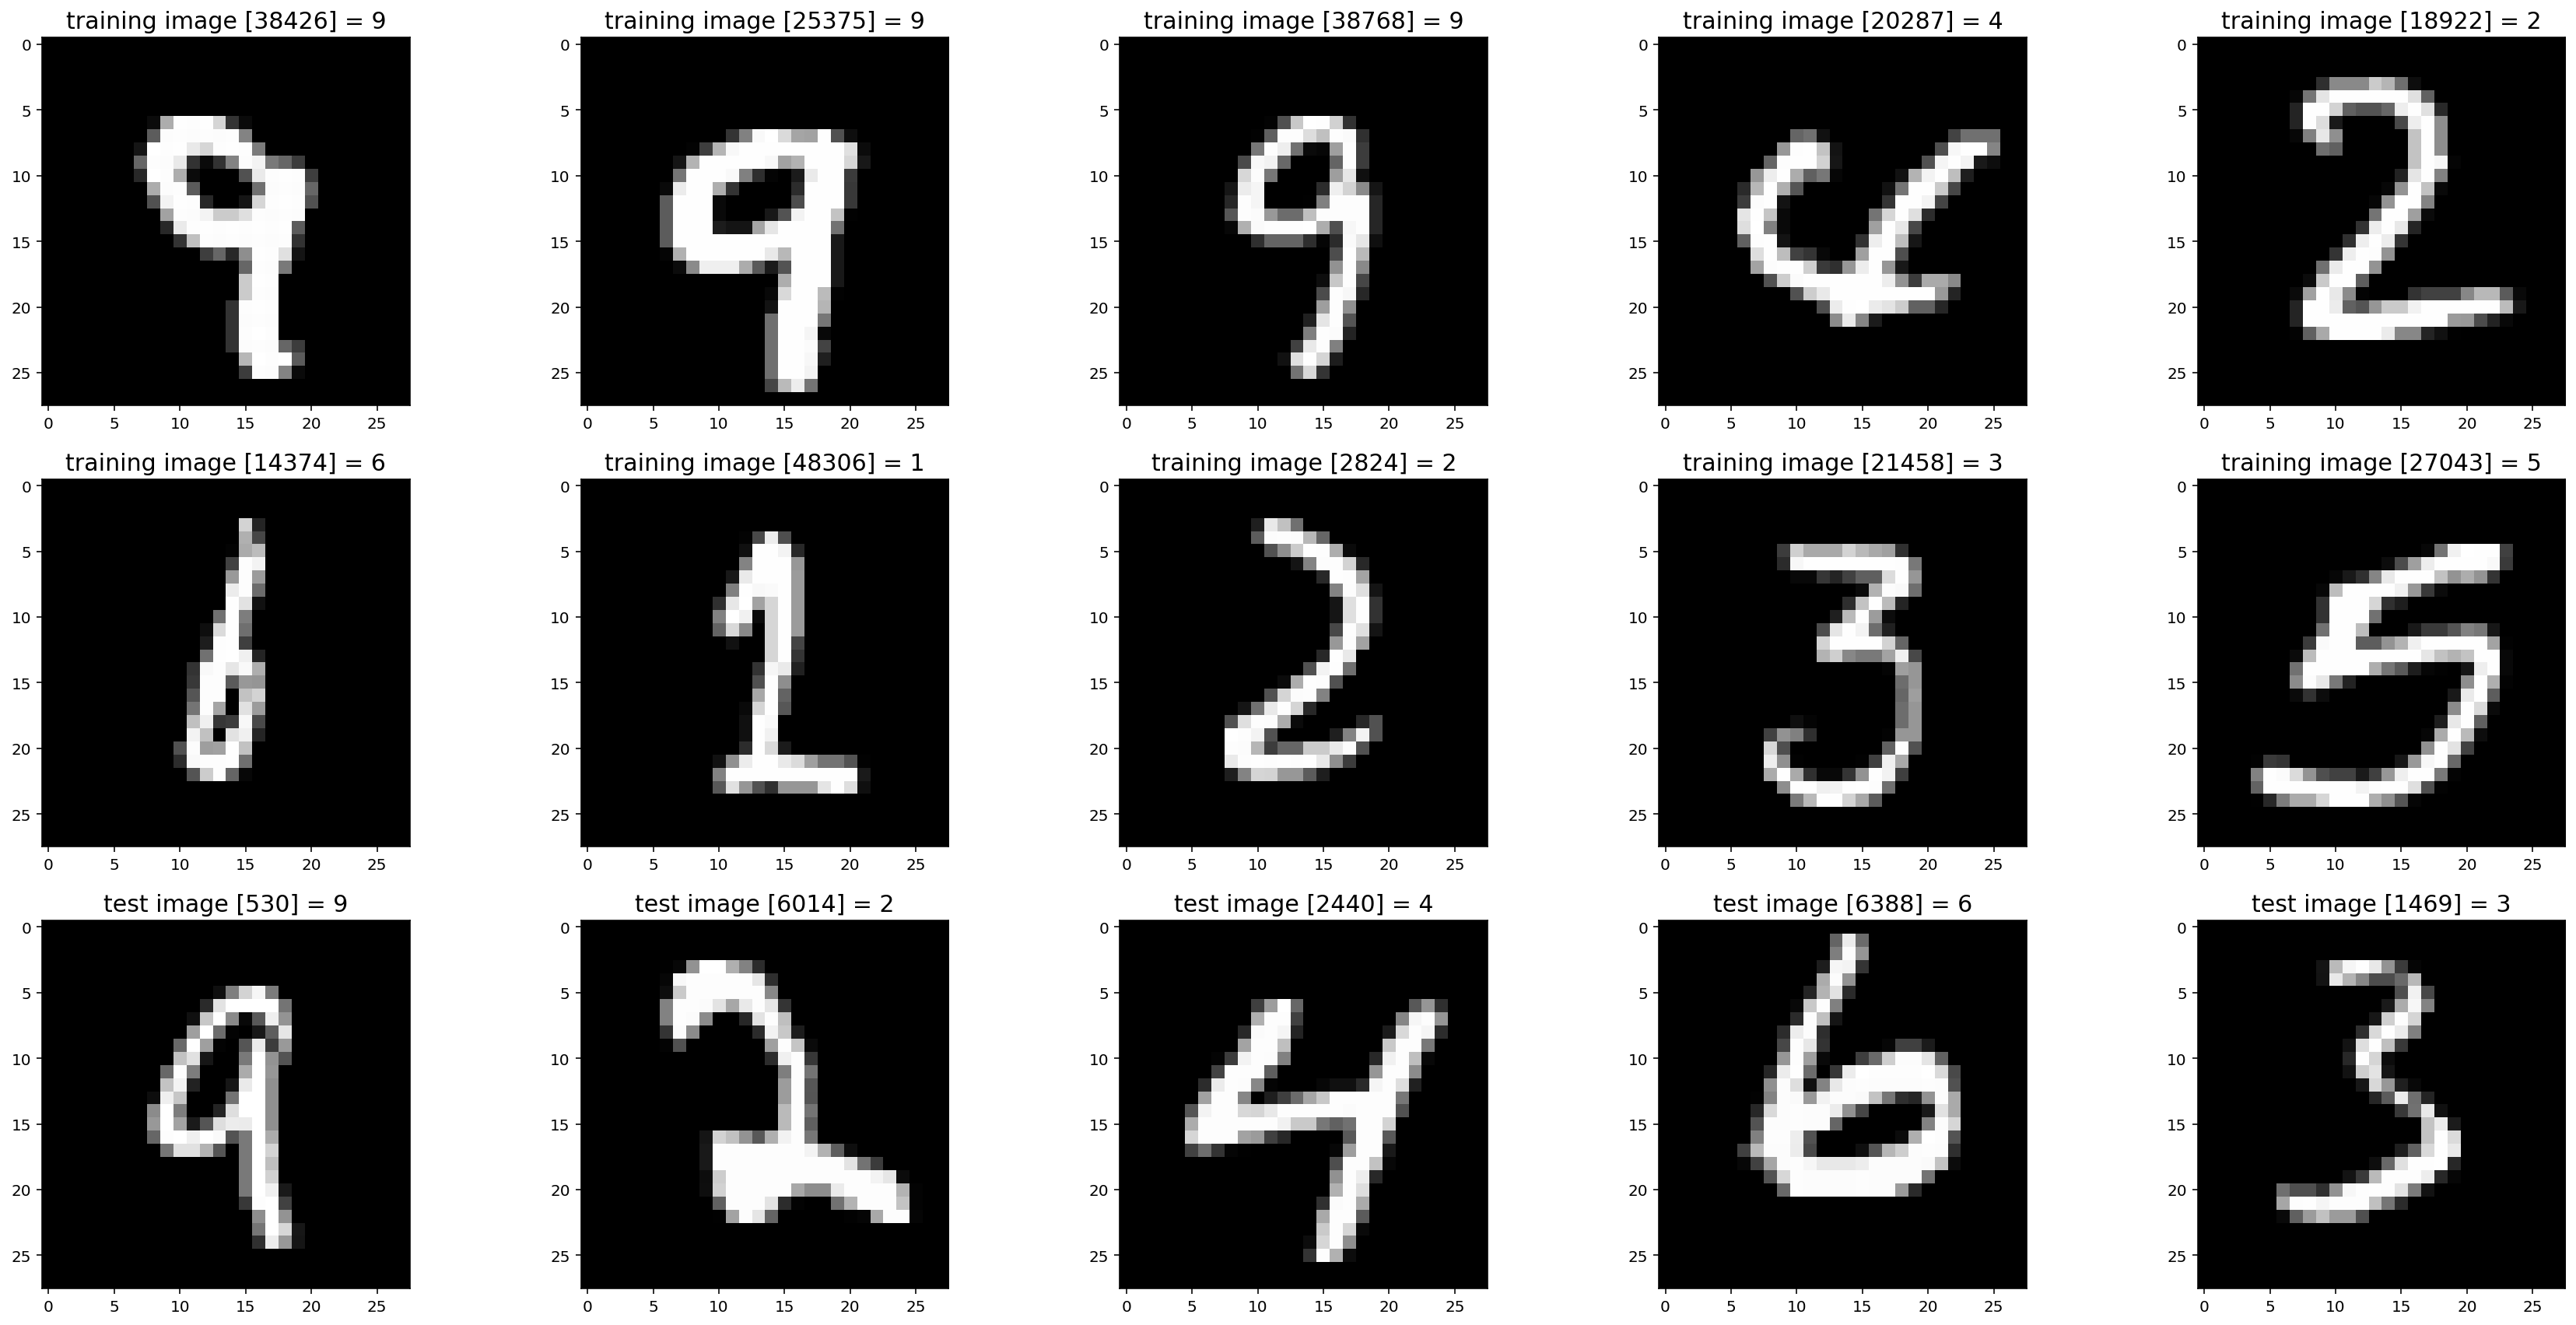

In [3]:
import numpy as np # linear algebra
import struct
from array import array
from os.path  import join

#
# MNIST Data Loader Class
##### COPIED FROM KAGGLE ######
class MnistDataloader(object):
    def __init__(self, training_images_filepath,training_labels_filepath,
                 test_images_filepath, test_labels_filepath):
        self.training_images_filepath = training_images_filepath
        self.training_labels_filepath = training_labels_filepath
        self.test_images_filepath = test_images_filepath
        self.test_labels_filepath = test_labels_filepath
    
    def read_images_labels(self, images_filepath, labels_filepath):        
        labels = []
        with open(labels_filepath, 'rb') as file:
            magic, size = struct.unpack(">II", file.read(8))
            if magic != 2049:
                raise ValueError('Magic number mismatch, expected 2049, got {}'.format(magic))
            labels = array("B", file.read())        
        
        with open(images_filepath, 'rb') as file:
            magic, size, rows, cols = struct.unpack(">IIII", file.read(16))
            if magic != 2051:
                raise ValueError('Magic number mismatch, expected 2051, got {}'.format(magic))
            image_data = array("B", file.read())        
        images = []
        for i in range(size):
            images.append([0] * rows * cols)
        for i in range(size):
            img = np.array(image_data[i * rows * cols:(i + 1) * rows * cols])
            img = img.reshape(28, 28)
            images[i][:] = img            
        
        return images, labels
            
    def load_data(self):
        x_train, y_train = self.read_images_labels(self.training_images_filepath, self.training_labels_filepath)
        x_test, y_test = self.read_images_labels(self.test_images_filepath, self.test_labels_filepath)
        return (x_train, y_train),(x_test, y_test)        
#
# Verify Reading Dataset via MnistDataloader class
#
#%matplotlib inline
import random
import matplotlib.pyplot as plt

#
# Set file paths based on added MNIST Datasets
#
input_path = 'Datafile/'
training_images_filepath = join(input_path, 'train-images-idx3-ubyte/train-images-idx3-ubyte')
training_labels_filepath = join(input_path, 'train-labels-idx1-ubyte/train-labels-idx1-ubyte')
test_images_filepath = join(input_path, 't10k-images-idx3-ubyte/t10k-images-idx3-ubyte')
test_labels_filepath = join(input_path, 't10k-labels-idx1-ubyte/t10k-labels-idx1-ubyte')

#
# Helper function to show a list of images with their relating titles
#
def show_images(images, title_texts):
    cols = 5
    rows = int(len(images)/cols) + 1
    plt.figure(figsize=(30,20))
    index = 1    
    for x in zip(images, title_texts):        
        image = x[0]        
        title_text = x[1]
        plt.subplot(rows, cols, index)        
        plt.imshow(image, cmap=plt.cm.gray)
        if (title_text != ''):
            plt.title(title_text, fontsize = 15);        
        index += 1

#
# Load MINST dataset
#
mnist_dataloader = MnistDataloader(training_images_filepath, training_labels_filepath, test_images_filepath, test_labels_filepath)
(x_train, y_train), (x_test, y_test) = mnist_dataloader.load_data()

### this code is my own ###
#duplicate the x train/test (the original is formatted as 28x28 matrices we need 1x784)
# the formatted versions keep the original format so that they can be used in the dislay
# the regular test and train will be used in the network

x_train_formatted = x_train[:]
x_test_formatted =  x_test[:]
#reshapes the data
for i in range(len(x_train)):
    ex = np.concatenate(x_train[i])
    ex = np.reshape(ex, (784, 1))
    x_train[i] = ex
for i in range(len(x_test)):
    ex = np.concatenate(x_test[i])
    ex = np.reshape(ex, (784, 1))
    x_test[i] = ex
"""
y_test = list(y_test)
for i in range(len(y_test)):
    ex = np.zeros((10, 1))
    ex[y_test[i]][0] = 1
    y_test[i] = ex
"""
# converts the y training data to matrix form as opposed to integer output.
# so that it can be easily subtracted to find the cost gradient of the output of the net
y_non_vector = y_train
y_train = list(y_train)
for i in range(len(y_train)):
    ex = np.zeros((10, 1))
    ex[y_train[i]][0] = 1
    y_train[i] = ex
### back to copied code ###
#
# Show some random training and test images 
#
images_2_show = []
titles_2_show = []
for i in range(0, 10):
    r = random.randint(1, 60000)
    images_2_show.append(x_train_formatted[r])
    titles_2_show.append('training image [' + str(r) + '] = ' + str(y_non_vector[r]))    

for i in range(0, 5):
    r = random.randint(1, 10000)
    images_2_show.append(x_test_formatted[r])        
    titles_2_show.append('test image [' + str(r) + '] = ' + str(y_test[r]))    

show_images(images_2_show, titles_2_show)

In [14]:
# creates the network and runs the gradient descent
MyNet = Network([784, 360, 120, 40, 10])
MyNet.SGD(list(zip(x_train, y_train)), 10, 500, 2, list(zip(x_test, y_test)))

/var/folders/fy/dny5m9612yd2m9c60t__y4z80000gn/T/ipykernel_6354/2531265123.py:148: RuntimeWarning: overflow encountered in exp
  return 1.0/(1.0+np.exp(-z))


Epoch 0: 2804 / 10000
Epoch 1: 4163 / 10000
Epoch 2: 4896 / 10000
Epoch 3: 5449 / 10000
Epoch 4: 5921 / 10000
Epoch 5: 6321 / 10000
Epoch 6: 6664 / 10000
Epoch 7: 6924 / 10000
Epoch 8: 7138 / 10000
Epoch 9: 7329 / 10000


In [19]:
MyNet.SGD(list(zip(x_train, y_train)), 10, 500, 1)
MyNet.evaluate(list(zip(x_test, y_test)))

/var/folders/fy/dny5m9612yd2m9c60t__y4z80000gn/T/ipykernel_6354/2531265123.py:148: RuntimeWarning: overflow encountered in exp
  return 1.0/(1.0+np.exp(-z))


Epoch: 0
Epoch: 1
Epoch: 2
Epoch: 3
Epoch: 4


KeyboardInterrupt: 

In [0]:
MyNet.sizes

/var/folders/fy/dny5m9612yd2m9c60t__y4z80000gn/T/ipykernel_6354/2531265123.py:148: RuntimeWarning: overflow encountered in exp
  return 1.0/(1.0+np.exp(-z))


Epoch: 0
0 1982
Epoch: 0
1 3598
Epoch: 0
2 4660
Epoch: 0
3 5367
Epoch: 0
4 5894
Epoch: 0
5 6306
Epoch: 0
6 6646
Epoch: 0
7 6863
Epoch: 0
8 7077
Epoch: 0
9 7253
Epoch: 0
10 7413
Epoch: 0
11 7528
Epoch: 0
12 7650
Epoch: 0
13 7742
Epoch: 0
14 7766
Epoch: 0
15 7835
Epoch: 0
16 7891
Epoch: 0
17 7953
Epoch: 0
18 8009
Epoch: 0
19 8065
Epoch: 0
20 8098
Epoch: 0
21 8132
Epoch: 0
22 8159
Epoch: 0
23 8194
Epoch: 0
24 8213
Epoch: 0
25 8247
Epoch: 0
26 8288
Epoch: 0
27 8309
Epoch: 0
28 8333
Epoch: 0
29 8360


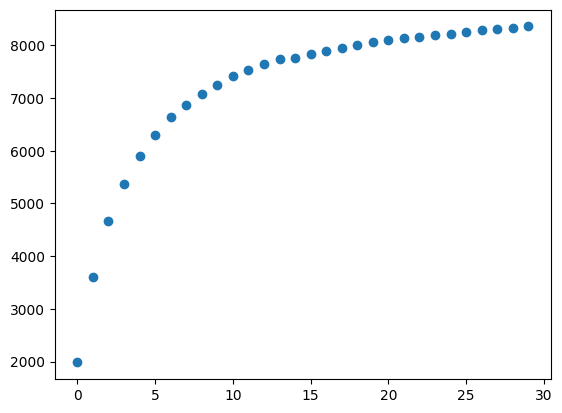

In [21]:
import matplotlib as plt
MyNet = Network([784, 360, 120, 40, 10])
x_data = []
y_data = []
for epoch in range(0, 30):
    MyNet.SGD(list(zip(x_train, y_train)), 1, 500, 2)
    x_data.append(epoch)
    y_data.append(MyNet.evaluate(list(zip(x_test, y_test))))
    print(x_data[-1], y_data[-1])
plt.pyplot.scatter(x_data, y_data)

In [26]:
map(lambda x:x/10, x_data)
x_data

In [2]:
import matplotlib.pyplot as plt

def plot_network(weights, biases):
    layers = len(weights) + 1
    fig, axs = plt.subplots(1, layers, figsize=(16, 8))
    axs[0].axis('off')
    axs[0].set_title('Input\nLayer')
    axs[-1].axis('off')
    axs[-1].set_title('Output\nLayer')
    for i, ax in enumerate(axs[1:-1], start=1):
        ax.axis('off')
        ax.set_title(f'Layer {i}')
        matrix = weights[i-1]
        n, m = matrix.shape
        pos = axs[i-1].get_position()
        pos_x0, pos_y0 = pos.x0, pos.y0
        pos_x1, pos_y1 = pos.x1, pos.y1
        gaps = [0.05]*(n+1)
        block_w = (pos_x1-pos_x0)/m
        block_h = (pos_y1-pos_y0)/n
        y_positions = [pos_y0 + gaps[0]*block_h]
        for j in range(n):
            y_positions.append(y_positions[-1] + (1+gaps[j+1])*block_h)
        for j in range(n):
            x_positions = [pos_x0 + gaps[0]*block_w]
            for k in range(m):
                x_positions.append(x_positions[-1] + (1+gaps[k+1])*block_w)
            for k in range(m):
                rect = plt.Rectangle((x_positions[k], y_positions[j]), block_w, block_h, fill=False)
                ax.add_patch(rect)
                ax.text(x_positions[k]+0.5*block_w, y_positions[j]+0.5*block_h, f"{matrix[j,k]:.2f}", ha='center', va='center')
        biases_matrix = biases[i-1]
        n, m = biases_matrix.shape
        pos_x0, pos_y0 = pos_x1, pos_y0
        pos_x1 += (pos_x1-pos_x0)/4
        y_positions = [pos_y0 + gaps[0]*block_h]
        for j in range(n):
            y_positions.append(y_positions[-1] + (1+gaps[j+1])*block_h)
        for j in range(n):
            x_positions = [pos_x0 + gaps[0]*block_w]
            for k in range(m):
                x_positions.append(x_positions[-1] + (1+gaps[k+1])*block_w)
            for k in range(m):
                rect = plt.Rectangle((x_positions[k], y_positions[j]), block_w, block_h, fill=False)
                ax.add_patch(rect)
                ax.text(x_positions[k]+0.5*block_w, y_positions[j]+0.5*block_h, f"{biases_matrix[j,k]:.2f}", ha='center', va='center')
    plt.show()